# Cortisol and BDI
Kiron Ang

---
## Introduction
This analysis uses the Python programming language in a Google Colab hosted runtime to find relationships in a dataset of 21,590 cortisol samples taken from a sample of people from a village in Dominica. These samples were collected from various times between 1989 and 1998. In July 2003, Beck Depression Inventory surveys were administered to some of the individuals in the previous cortisol collection group. The goal of this analysis is to determine the best way to collect and analyze cortisol data, and how to integrate cortisol data with BDI data.

## Methods
The Python libraries used in this analysis are displayed below, along with their version numbers.

In [1]:
!python -V

!pip install -U scikit-learn > output.txt
import sklearn
print("scikit-learn", sklearn.__version__)

!pip install -U matplotlib > output.txt
import matplotlib
print("matplotlib", matplotlib.__version__)

!pip install -U seaborn > output.txt
import seaborn
print("seaborn", seaborn.__version__)

!pip install -U polars > output.txt
import polars
print("polars", polars.__version__)

Python 3.10.12
scikit-learn 1.5.2
matplotlib 3.7.1
seaborn 0.13.2
polars 1.7.1


The dataset is NOT publicly available as of writing. Additionally, some data cleaning and preparation was done outside of this Google Colab for privacy reasons.

In [2]:
data = polars.read_csv("data.csv")
data

person_id,sample_id,batch_id,qc2,qc3,cortisol_micrograms_per_deciliter,sample_date,collection_time_minutes,awakening_time_minutes,minutes_awake,gender,birth_year
i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64
241220,8465,123,24.2,48.6,0.114,19980728,695,345,350,1,1992
241220,8466,122,25.5,50.0,0.0695,19980728,614,345,269,1,1992
241220,8468,121,27.4,50.0,0.26,19980728,505,345,160,1,1992
241220,8469,125,27.2,47.3,0.0985,19980730,623,420,203,1,1992
241220,8470,125,27.2,47.3,0.2335,19980730,490,420,70,1,1992
…,…,…,…,…,…,…,…,…,…,…,…
999414592,2693,123,24.2,48.6,0.1675,19980728,665,363,302,1,1986
999414592,2694,113,21.27,48.83,0.14356,19950721,615,390,225,1,1986
999414592,2695,64,17.9,28.8,0.207,19920808,450,360,90,1,1986


The significance of each column is given below:

- "**person_id**": Identification number of the person from whom the sample was collected.
- "**sample_id**": Identification number of the sample. Each row in the dataset represents a salivary cortisol sample collected.
- "**batch_id**": UNKNOWN
- "**qc2**": UNKNOWN
- "**qc3**": UNKNOWN
- "**cortisol_micrograms_per_deciliter**": Raw cortisol measurement from the salivary sample collected in micrograms per deciliter.
- "**sample_date**": Date the sample was collected, in the format YYYYMMDD.
- "**collection_time_minutes**": Time during the day when the sample was collected. The unit here is minutes from midnight.
- "**awakening_time_minutes**": Time during the day when the participant reported they woke up. The unit here is minutes from midnight.
- "**minutes_awake**": Calculated by subtracting the previous two columns.
- "**gender**": Gender of the participant from whom the sample was taken. 1 is female, 0 is male.
- "**birth_year**": Birth year of the participant. Most participants were missing an exact birth date in the record so this was chosen instead.

I prepared this data in Google Sheets to reformat, code, and convert some of the columns. A graduate student in the Dominica Family Health Lab, Edward "Teddy" Thum, had previously cleaned and compiled this massive amount of data. I owe many thanks to him for giving me data in a workable state.

First, I generated histograms of each variable. I wanted to see what kinds of quality control actions I should take.


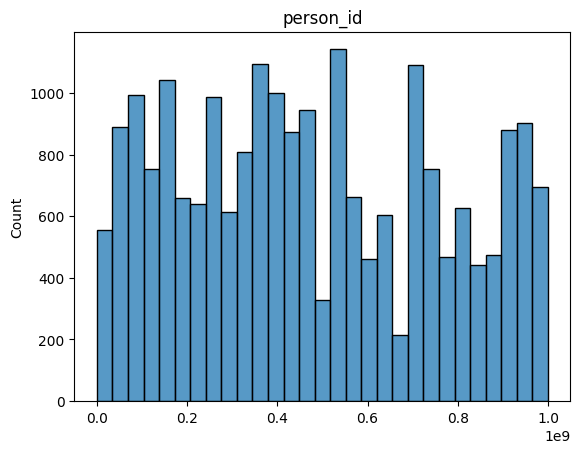

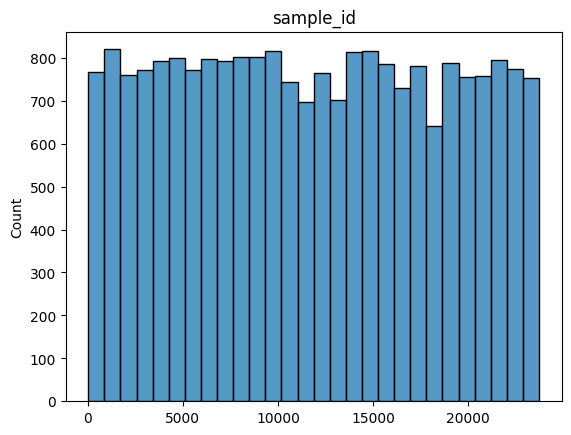

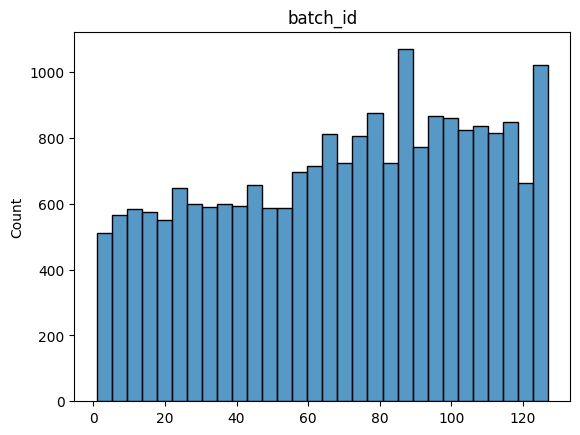

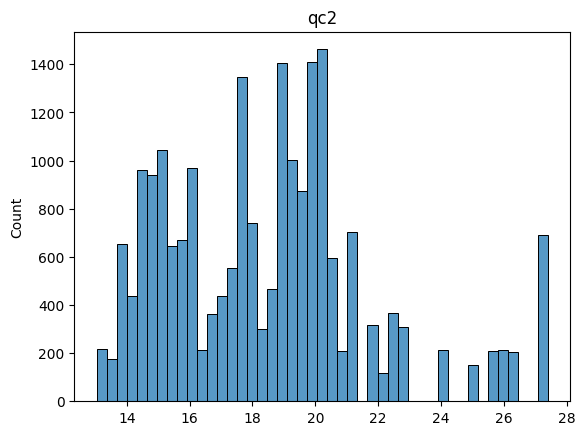

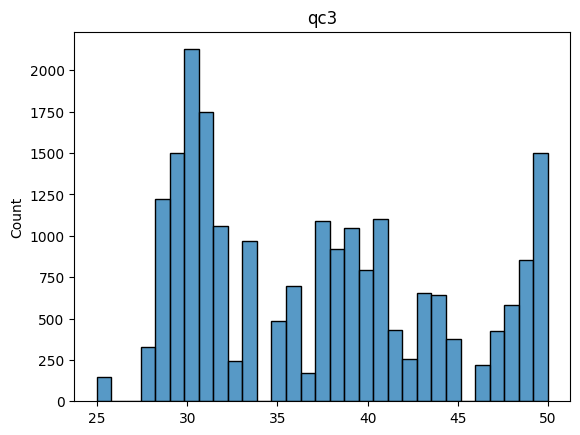

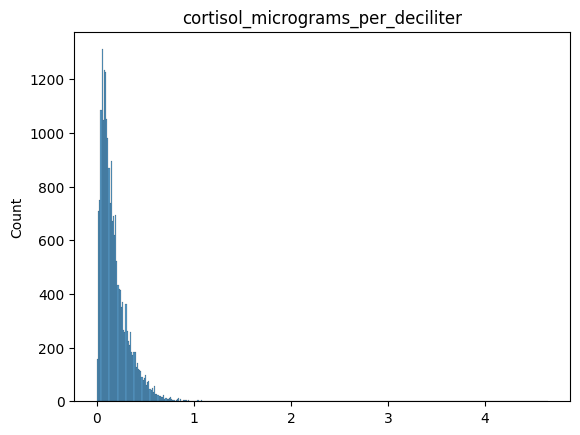

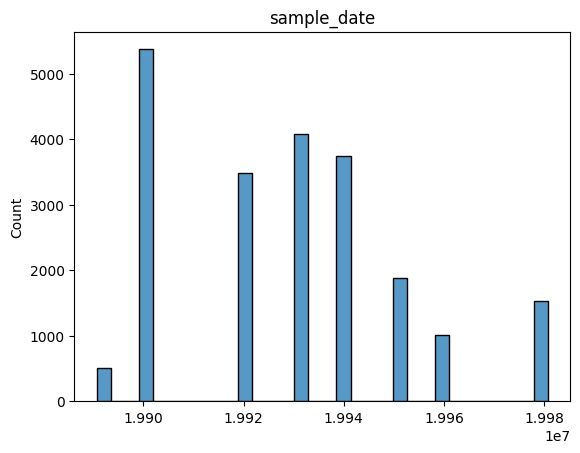

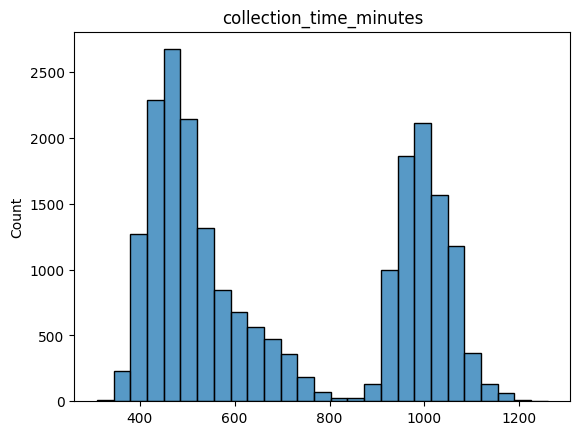

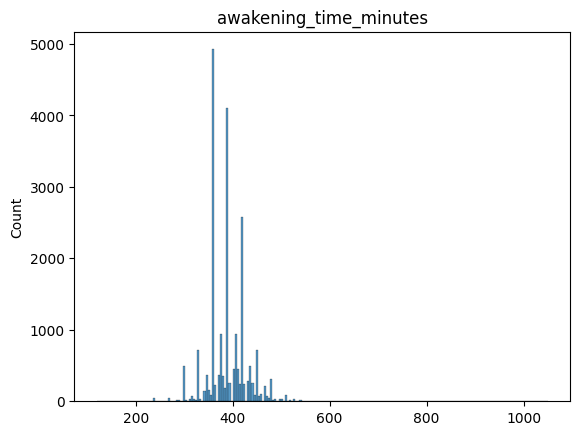

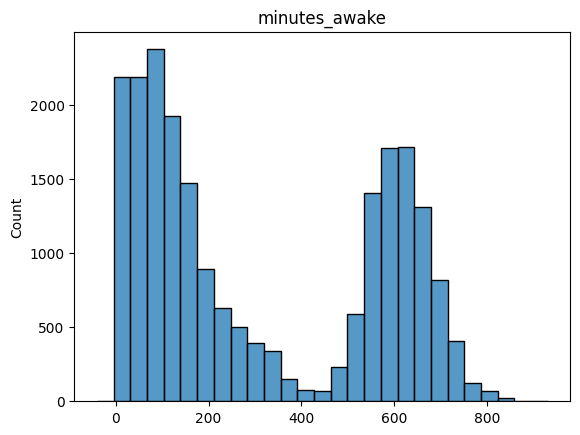

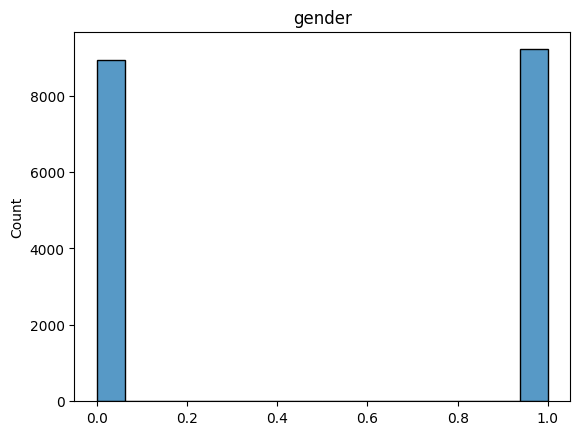

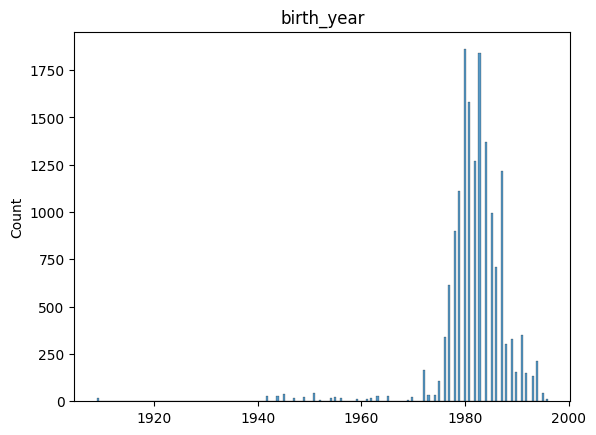

In [3]:
import matplotlib.pyplot
for column in data.columns:
  seaborn.histplot(data[column])
  matplotlib.pyplot.title(column)
  matplotlib.pyplot.show()

Based on this, I can see that some of the features have extreme outliers. I want to at least see whether a machine learning algorithm can still perform decently on the data in its current state, so I will use the HistGradientBoostingRegressor class from *scikit-learn* as described here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html. This is effective for the data because the input features in the data contain many NA values and it should be able to handle the non-linear relationship between the input features and cortisol.

I first make a basic pipeline with some tools in *scikit-learn*.

In [10]:
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.ensemble

pipeline = sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.RobustScaler(),
                sklearn.ensemble.HistGradientBoostingRegressor()
            )
pipeline

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

Then, I split the data into training and testing sets. I will only use five features as input to predict "cortisol_micrograms_per_deciliter".

In [11]:
import sklearn.model_selection

X = data[["collection_time_minutes", "awakening_time_minutes", "minutes_awake", "gender", "birth_year"]]
y = data["cortisol_micrograms_per_deciliter"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

print("Number of rows in X_train:", len(X_train))
print("Number of rows in X_test:", len(X_test))
print("Number of rows in y_train:", len(y_train))
print("Number of rows in y_test:", len(y_test))

Number of rows in X_train: 16192
Number of rows in X_test: 5398
Number of rows in y_train: 16192
Number of rows in y_test: 5398


Regression metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

In [15]:
import sklearn.metrics

pipeline.fit(X_train, y_train)

y_predict = pipeline.predict(X_test)

mae = sklearn.metrics.mean_absolute_error(y_test, y_predict)
mse = sklearn.metrics.mean_squared_error(y_test, y_predict)
rmse = sklearn.metrics.mean_squared_error(y_test, y_predict, squared=False)
r2 = sklearn.metrics.r2_score(y_test, y_predict)
explained_variance = sklearn.metrics.explained_variance_score(y_test, y_predict)
max_error = sklearn.metrics.max_error(y_test, y_predict)
median_absolute_error = sklearn.metrics.median_absolute_error(y_test, y_predict)
mean_absolute_percentage_error = sklearn.metrics.mean_absolute_percentage_error(y_test, y_predict)
mean_squared_log_error = sklearn.metrics.mean_squared_log_error(y_test, y_predict)
mean_poisson_deviance = sklearn.metrics.mean_poisson_deviance(y_test, y_predict)
mean_tweedie_deviance = sklearn.metrics.mean_tweedie_deviance(y_test, y_predict)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Explained Variance:", explained_variance)
print("Max Error:", max_error)
print("Median Absolute Error:", median_absolute_error)
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error)
print("Mean Squared Log Error:", mean_squared_log_error)
print("Mean Poisson Deviance:", mean_poisson_deviance)
print("Mean Tweedie Deviance:", mean_tweedie_deviance)

MAE: 0.07258173462721534
MSE: 0.012330765630278424
RMSE: 0.11104398061254118
R²: 0.44722693711262074
Explained Variance: 0.4472346972999707
Max Error: 1.684140583776555
Median Absolute Error: 0.04970830288703615
Mean Absolute Percentage Error: 156300267657.58566
Mean Squared Log Error: 0.0069375351405854884
Mean Poisson Deviance: 0.053427116323156554
Mean Tweedie Deviance: 0.012330765630278424


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


placeholder